In [3]:
!pip install sentence-transformers

  Using cached sentence_transformers-2.2.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.0 MB/s eta 0:00:0000:0100:01
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Using cached regex-2023.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached safetensors-0.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install datasets
!pip install  accelerate -U 


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Using cached accelerate-0.21.0-py3-none-any.whl (244 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.19.0
    Uninstalling accelerate-0.19.0:
      Successfully uninstalled accelerate-0.19.0

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# finetune 模型

In [8]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from datasets import load_dataset
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
import torch
import logging

In [9]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt = '%Y-%m-%d %H:%M:S', level=logging.INFO, handlers =[LoggingHandler()] )

## 从hf加载模型

In [101]:
modelB = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

2023-07-31 09:31:S - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
2023-07-31 09:31:S - Use pytorch device: cuda


In [4]:
# dataset_id = "embedding-data/sentence-compression"
# dataset = load_dataset(dataset_id)

In [11]:
import os,datasets
filenames = os.listdir('topwar_faq')
filenames

['3_faq.faq', '.ipynb_checkpoints', '1_faq.faq', '4_faq.faq', '2_faq.faq']

In [13]:
def parse_faq(file_content,QA_SEP='====='):
    arr = file_content.split(QA_SEP)
    list_arr = []
    for item in arr:
        question, answer = item.strip().split("\n", 1)
        question = question.replace("Question: ", "")
        answer = answer.replace("Answer: ", "")
        list_arr.append((answer,question))
    return list_arr

all_datas = []
for fn in filenames:
    if fn == '.ipynb_checkpoints':
        continue
    with open(f"topwar_faq/{fn}") as f:
        data = f.read()
        all_datas += parse_faq(data)
print(f"data size:{len(all_datas)}")

data size:126


In [14]:
train_examples = []

for i in range(len(all_datas)):
    example = all_datas[i]
    train_examples.append(InputExample(texts=[example[0], example[1]],label = [0.85]*len(all_datas)))

In [15]:

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)
train_loss = losses.MultipleNegativesRankingLoss(model=modelB)
num_epochs = 10
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [18]:
torch.cuda.empty_cache()
modelB.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
           # evaluator=evaluator,
            evaluation_steps=5,
           output_path='./finetuned-sentence-embedding',
          warmup_steps=warmup_steps)

Epoch: 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


2023-07-31 02:55:S - Save model to ./finetuned-sentence-embedding


In [19]:
# modelB.evaluate(evaluator)

## 从本地加载finetuned的模型

In [116]:
modelB = SentenceTransformer('./finetuned-sentence-embedding')

2023-08-01 08:35:S - Load pretrained SentenceTransformer: ./finetuned-sentence-embedding
2023-08-01 08:35:S - Use pytorch device: cuda


In [117]:
input_sentences_a = ['专属技能碎片可以通过多种途径获得，例如礼包商城-特惠礼包界面可以购买专属技能碎片礼包', 
                  '中国首都在北京',
                  '美国首都在华盛顿']
input_sentences_q = ['专属技能碎片在哪里？',
                   '中国首都在哪里？',
                   '美国首都在哪里？']

embeddings = modelB.encode(input_sentences_a+input_sentences_q)

Batches: 100%|██████████| 1/1 [00:00<00:00, 56.37it/s]


In [118]:
from sentence_transformers import evaluation,util

util.cos_sim(embeddings[:3],embeddings[3:])

tensor([[ 0.7496, -0.0593, -0.0969],
        [-0.0216,  0.8824,  0.5007],
        [-0.0075,  0.5930,  0.8479]])

In [119]:
input_answer  = []
input_question  = []
for i, (a,b) in enumerate (all_datas):
        input_answer.append(a)
        input_question.append(b)

In [120]:
emb_answer = modelB.encode(input_answer)
emb_question = modelB.encode(input_question)

Batches: 100%|██████████| 4/4 [00:00<00:00, 31.72it/s]


In [121]:
len(input_question),len(input_answer)

(126, 126)

## 将question和answer进行cross 对比，生成126*126个结果，再查看这个分布

In [122]:
cross_simsvalues = util.cos_sim(emb_answer,emb_question).flatten()

In [123]:
cross_sims_s = pd.Series(cross_simsvalues)

In [124]:
N = len(input_question)
pos_indices = [ i*N+i for i in range(N)] ##正例的index

In [125]:
# 正样本的得分
pos_cross_sims_s = cross_sims_s[pos_indices]
pos_cross_sims_s.describe()

count    126.000000
mean       0.655297
std        0.099786
min        0.439509
25%        0.583280
50%        0.661202
75%        0.720619
max        0.912604
dtype: float64

In [126]:
#负样本得分
neg_cross_sims_s = cross_sims_s.drop(pos_indices)
neg_cross_sims_s.describe()

count    15750.000000
mean         0.099584
std          0.123988
min         -0.246504
25%          0.015882
50%          0.086160
75%          0.162934
max          0.813635
dtype: float64

<Axes: ylabel='Count'>

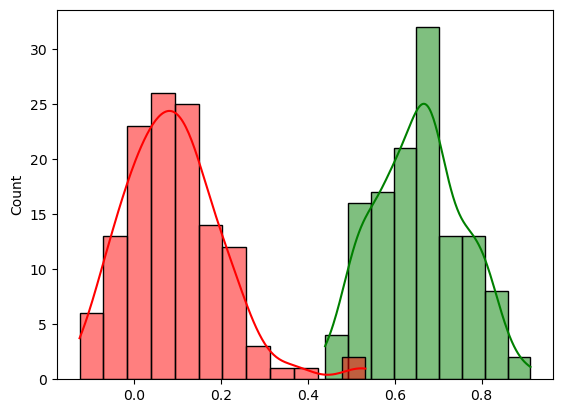

In [127]:
import seaborn as sns
sns.histplot(pos_cross_sims_s, color='green',kde=True)
 ##负样本较多，只采样一部分进行plot
sns.histplot(neg_cross_sims_s.sample(N), color='red',kde=True)

## 输出具体的结果

In [128]:
import numpy as np
def similarity(v1,v2):
    dot_product = np.dot(v1, v2)

    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)

    return dot_product / (magnitude_v1 * magnitude_v2)

In [ ]:
for i in range(len(input_question)):
    sims = similarity(emb_answer[i],emb_question[i])
    print(f"Question:{input_question[i]}\nAnswer:{input_answer[i]}\n{sims}\n")

In [131]:
input_queries = ['雷电将军好不好使？']
q_embedding = modelB.encode(input_queries)
results = util.semantic_search(query_embeddings = q_embedding,corpus_embeddings= emb_answer,top_k=3)
results

Batches: 100%|██████████| 1/1 [00:00<00:00, 89.53it/s]


[[{'corpus_id': 117, 'score': 0.36897891759872437},
  {'corpus_id': 35, 'score': 0.36897891759872437},
  {'corpus_id': 120, 'score': 0.35904332995414734}]]

In [65]:
similarity(q_embedding[0],emb_answer[93])

0.4407898

In [212]:
for ret in results[0]:
    print(f"{all_datas[ret['corpus_id']]} score:{ret['score']}")

('全力交锋--战斗阶段开始后，跨服到其它战区后，除了攻打首府和两个2个王者遗迹-守卫外（其他遗迹和发射塔为和平状态，不可攻击），还可以攻打该服玩家的城堡，采集田和强化弱化塔。', '战斗阶段是否可以攻击其他战区指挥官？') score:0.4162951409816742
('玩家拥有建筑的占领权后，拥有【先锋】权限的玩家，可以开启对决。开启对决后，该玩家在此建筑中的所有部队都将会进入对决状态中，其他势力的拥有【先锋】权限的玩家，可以发起对决；当击败玩家所有进入对决状态的部队后，视为攻击成功。对决连续守住一定的攻击次数，或守住规定的时间，则对决成功，否则对决失败。对决获胜，可获得一定时间的无敌时间，并立即摧毁一定的城防值；对决失败，则击败对决的玩家获得建筑的控制权。', '先锋对决怎么玩，胜负规则是什么？') score:0.33781808614730835
('您好，破浪突袭者BW-3的控制技能主要体现在 技能中有一项是潮汐震荡，如果被击目标处在攻击力降低状态，50%概率对其附加[眩晕]（无法普攻和释放主动技能）。从技能定位来看，其更偏向攻击，但防守效果也不错。', '小蓝是拥有控制技能的重装机兵，这个控制技能怎么理解？它更适合攻击还是防守？') score:0.29779693484306335


# 使用pre trained 模型对比

In [136]:
from transformers import AutoTokenizer,AutoModel
import torch

In [137]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [138]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0].to(device) #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float().to(device)
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def load_model(model_location):    
    tokenizer = AutoTokenizer.from_pretrained(model_location)
   
    model = AutoModel.from_pretrained(
        model_location, 
        # device_map="balanced_low_0", 
        #load_in_8bit=True
    )
    # load the model on GPU
    model.to(device) 
    model.eval()
    
    return model, tokenizer

In [171]:
model_location = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
modelA,tokenizer  = load_model(model_location)

In [172]:
encoded_input = tokenizer(input_question, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

In [173]:
with torch.no_grad():
    model_output = modelA(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings_q = mean_pooling(model_output, encoded_input['attention_mask']).to(device).cpu().numpy()

In [174]:
encoded_input = tokenizer(input_answer, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
with torch.no_grad():
    model_output = modelA(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings_a = mean_pooling(model_output, encoded_input['attention_mask']).to(device).cpu().numpy()

In [ ]:
for i in range(len(input_question)):
    sims = similarity(sentence_embeddings_a[i],sentence_embeddings_q[i])
    print(f"Question:{input_question[i]}\nAnswer:{input_answer[i]}\n{sims}\n")

In [213]:
input_queries = ['怎么攻击别人?']
encoded_input = tokenizer(input_queries, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
with torch.no_grad():
    model_output = modelA(**encoded_input)

q_embedding = mean_pooling(model_output, encoded_input['attention_mask']).to(device).cpu().numpy()

In [214]:
results = util.semantic_search(query_embeddings = q_embedding,corpus_embeddings= sentence_embeddings_a,top_k=3)
results
for ret in results[0]:
    print(f"{all_datas[ret['corpus_id']]} score:{ret['score']}")

('您好，[援护]效果不分担燃烧伤害（除燃烧伤害外，都可以分担）。拥有点燃技能的英雄目前有寂，914，马克西莫，异化娜迪亚等。', '尤里卡突袭者的[援护]效果是否能分担各种英雄技能打出的伤害？') score:0.44886574149131775
('玩家拥有建筑的占领权后，拥有【先锋】权限的玩家，可以开启对决。开启对决后，该玩家在此建筑中的所有部队都将会进入对决状态中，其他势力的拥有【先锋】权限的玩家，可以发起对决；当击败玩家所有进入对决状态的部队后，视为攻击成功。对决连续守住一定的攻击次数，或守住规定的时间，则对决成功，否则对决失败。对决获胜，可获得一定时间的无敌时间，并立即摧毁一定的城防值；对决失败，则击败对决的玩家获得建筑的控制权。', '先锋对决怎么玩，胜负规则是什么？') score:0.4420698285102844
('您好，破浪突袭者BW-3的控制技能主要体现在 技能中有一项是潮汐震荡，如果被击目标处在攻击力降低状态，50%概率对其附加[眩晕]（无法普攻和释放主动技能）。从技能定位来看，其更偏向攻击，但防守效果也不错。', '小蓝是拥有控制技能的重装机兵，这个控制技能怎么理解？它更适合攻击还是防守？') score:0.43532323837280273


In [2]:
input_queries = ['中国的首都在哪里？','中国的首都在北京']
encoded_input = tokenizer(input_queries, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
with torch.no_grad():
    model_output = modelA(**encoded_input)

embedding = mean_pooling(model_output, encoded_input['attention_mask']).to(device).cpu().numpy()

NameError: name 'tokenizer' is not defined

# 部署模型到sagemaker

In [12]:
!pip install -U sagemaker

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 8.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached PyYAML-6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (682 kB)
  Created wheel for sagemaker: filename=sagemaker-2.169.0-py2.py3-none-any.whl size=1158252 sha256=0ec721d00f4427b64ea6d9d4e052bb5989328fde366bb4acd16933fb90d67f82
  Stored in directory: /root/.cache/pip/wheels/42/17/69/c2089332a0db669b4a27888e1d76e825168014112d5eb44231
Successfully built sagemaker
  Attempting uninstall: PyYAML
    Found existing installation:

## 2. 把模型拷贝到S3为后续部署做准备

In [80]:
import sagemaker
from sagemaker import image_uris
import boto3
import os
import time
import json

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

In [81]:
s3_model_prefix = "LLM-RAG/workshop/finetuned-sentence2emb-model"  # folder where model checkpoint will go
model_snapshot_path = "./finetuned-sentence-embedding"
s3_code_prefix = "LLM-RAG/workshop/finetuned-sentence2emb_deploy_code"
print(f"s3_code_prefix: {s3_code_prefix}")
print(f"model_snapshot_path: {model_snapshot_path}")

s3_code_prefix: LLM-RAG/workshop/finetuned-sentence2emb_deploy_code
model_snapshot_path: ./finetuned-sentence-embedding


In [82]:
!aws s3 cp --recursive {model_snapshot_path} s3://{bucket}/{s3_model_prefix}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
upload: finetuned-sentence-embedding/config_sentence_transformers.json to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/config_sentence_transformers.json
upload: finetuned-sentence-embedding/config.json to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/config.json
upload: finetuned-sentence-embedding/1_Pooling/config.json to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/1_Pooling/config.json
upload: finetuned-sentence-embedding/modules.json to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/modules.json
upload: finetuned-

### 3. 模型部署准备（entrypoint脚本，容器镜像，服务配置）

In [83]:
inference_image_uri = (
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117"
)

#中国区需要替换为下面的image_uri
# inference_image_uri = (
#     f"727897471807.dkr.ecr.{region}.amazonaws.com.cn/djl-inference:0.21.0-deepspeed0.8.3-cu117"
# )

print(f"Image going to be used is ---- > {inference_image_uri}")

Image going to be used is ---- > 763104351884.dkr.ecr.us-east-2.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117


In [84]:
!mkdir -p sentence2emb_deploy_code

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
%%writefile sentence2emb_deploy_code/model.py
from djl_python import Input, Output
import torch
import logging
import math
import os
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, AutoModel

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'--device={device}')


def load_model(properties):
    tensor_parallel = properties["tensor_parallel_degree"]
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_location)
   
    model = AutoModel.from_pretrained(
        model_location, 
        # device_map="balanced_low_0", 
        #load_in_8bit=True
    )
    # load the model on GPU
    model.to(device) 
    model.requires_grad_(False)
    model.eval()
    
    return model, tokenizer


model = None
tokenizer = None
generator = None

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0].to(device) #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float().to(device)
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def handle(inputs: Input):
    global model, tokenizer
    if not model:
        model, tokenizer = load_model(inputs.get_properties())

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()
    
    input_sentences = data["inputs"]
    params = data["parameters"]
    logging.info(f"inputs: {input_sentences}")
    logging.info(f"parameters: {params}")
    
    encoded_input = tokenizer(input_sentences, padding=True, truncation=True, return_tensors='pt').to(device)
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling. In this case, max pooling.
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask']).to(device).cpu().numpy()

#     # preprocess
#     input_ids = tokenizer(input_sentences, return_tensors="pt").input_ids
#     # pass inputs with all kwargs in data
#     if params is not None:
#         outputs = model.generate(input_ids, **params)
#     else:
#         outputs = model.generate(input_ids)

#     # postprocess the prediction
#     prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    result = {"sentence_embeddings": sentence_embeddings}
    return Output().add_as_json(result)

Overwriting sentence2emb_deploy_code/model.py


#### Note: option.s3url 需要按照自己的账号进行修改

In [86]:
%%writefile sentence2emb_deploy_code/serving.properties
engine=Python
option.tensor_parallel_degree=1
option.s3url = s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/

Overwriting sentence2emb_deploy_code/serving.properties


In [87]:
!rm s2e_model.tar.gz
!cd sentence2emb_deploy_code && rm -rf ".ipynb_checkpoints"
!tar czvf s2e_model.tar.gz sentence2emb_deploy_code

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
sentence2emb_deploy_code/
se

In [88]:
s3_code_artifact = sess.upload_data("s2e_model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb_deploy_code/s2e_model.tar.gz


### 4. 创建模型 & 创建endpoint

In [89]:
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base("finetuned-paraphrase") #Note: Need to specify model_name
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

finetuned-paraphrase-2023-07-05-03-14-23-508
Image going to be used is ---- > 763104351884.dkr.ecr.us-east-2.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117
Created Model: arn:aws:sagemaker:us-east-2:946277762357:model/finetuned-paraphrase-2023-07-05-03-14-23-508


###  如果批量创建索引量较多，建议改成"InstanceType": "ml.g4dn.xlarge",

In [90]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 10*60,
        },
    ],
)
endpoint_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-2:946277762357:endpoint-config/finetuned-paraphrase-2023-07-05-03-14-23-508-config',
 'ResponseMetadata': {'RequestId': '0b754ef3-6cb2-4243-bd14-518fbf35d080',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0b754ef3-6cb2-4243-bd14-518fbf35d080',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '132',
   'date': 'Wed, 05 Jul 2023 03:14:30 GMT'},
  'RetryAttempts': 0}}

In [92]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_1225/4188345917.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1225/4188345917.py'                         │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/botocore/client.py:530 in _api_call                      │
│                                                                                                  │
│    527 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    528 │   │   │   │   )                                                                         │
│    529 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  530 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    531 │   │                                                                                     │
│    532 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    533                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/botocore/client.py:960 in _make_api_call                 │
│                                                                                                  │
│    957 │   │   if http.status_code >= 300:                                                       │
│    958 │   │   │   error_code = parsed_response.get("Error", {}).get("Code")                     │
│    959 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱  960 │   │   │   raise error_class(parsed_response, operation_name)                            │
│    961 │   │   else:                                                                             │
│    962 │   │   │   return parsed_response                                                        │
│    963                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create 
already existing endpoint 
"arn:aws:sagemaker:us-east-2:946277762357:endpoint/finetuned-paraphrase-2023-07-05-03-14-23-508-endpoint".

In [33]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: InService
Arn: arn:aws:sagemaker:us-east-2:946277762357:endpoint/finetuned-paraphrase-2023-07-04-16-08-10-303-endpoint
Status: InService


## 5. 模型测试

In [34]:
def get_vector_by_sm_endpoint(questions, sm_client, endpoint_name):
    parameters = {
        "max_new_tokens": 50,
        "temperature": 0,
        "min_length": 10,
        "no_repeat_ngram_size": 2,
    }

    response_model = sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "inputs": questions,
                "parameters": parameters
            }
        ),
        ContentType="application/json",
    )
    json_str = response_model['Body'].read().decode('utf8')
    json_obj = json.loads(json_str)
    embeddings = json_obj['sentence_embeddings']
    return embeddings

In [38]:
prompts1 = """专属技能碎片在哪里获得？"""
prompts1 = """中国首都在哪里？"""

emb1 = get_vector_by_sm_endpoint(prompts1, smr_client, endpoint_name)

In [39]:
prompts2 = """专属技能碎片可以通过多种途径获得，例如礼包商城-特惠礼包界面可以购买专属技能碎片礼包"""
emb2 = get_vector_by_sm_endpoint(prompts2, smr_client, endpoint_name)

In [40]:
util.cos_sim(emb1,emb2)

tensor([[-0.0653]])